In [172]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, HBox, VBox, Button, interactive_output, Label, Dropdown
from IPython.display import display
import math

%matplotlib inline


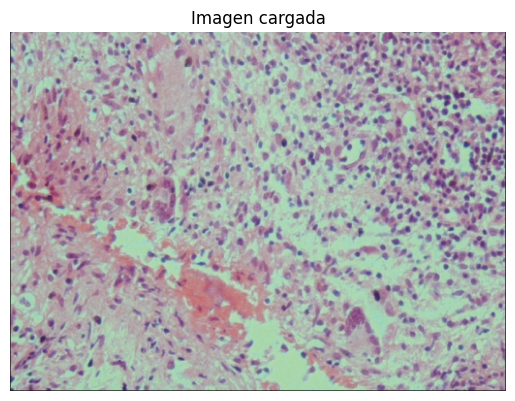

In [173]:
ruta_imagen2 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/person100_bacteria_475.jpeg'
ruta_imagen3 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/Te-glTr_0003.jpg'
ruta_imagen4 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/174670.JPG'
ruta_imagen5 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/Te-me_0021.jpg'
ruta_imagen5 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/PruebaProfe2.jpg'

ruta_imagen5 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/Noisy1.png'
ruta_imagen5 = 'C:/Users/paulo/Documents/UNIR/Vision Artificial/Actividad 2/NIH6.png'

img = cv2.imread(ruta_imagen5)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Para que se muestre bien en matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Para que se muestre bien en matplotlib
if img is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")
plt.imshow(img, cmap='gray')
plt.title("Imagen cargada")
plt.axis('off')
plt.show()

def cargar_imagen(ruta):
    img = cv2.imread(ruta)
    if img is None:
        raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [174]:
def get_kernel(shape, size):
    if shape == 'Cuadrado':
        cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    elif shape == 'Cruz':
        return cv2.getStructuringElement(cv2.MORPH_CROSS, (size, size))
    elif shape == 'Elipse':
        return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
    else:
        return np.ones((size, size), np.uint8)
    
def calcular_mse(original, procesada):
    err = np.mean((original.astype("float32") - procesada.astype("float32")) ** 2)
    return err

def calcular_psnr(original, procesada):
    mse = calcular_mse(original, procesada)
    if mse == 0:
        return float('inf')  # las imágenes son iguales
    max_pixel = 255.0
    psnr = 10 * math.log10((max_pixel ** 2) / mse)
    return psnr

def calcular_snr(original, procesada):
    señal = np.mean(original.astype("float32") ** 2)
    ruido = np.mean((original.astype("float32") - procesada.astype("float32")) ** 2)
    if ruido == 0:
        return float('inf')
    return 10 * np.log10(señal / ruido)

In [175]:
def aplicar_transformaciones(
    brillo, contraste, gamma,
    logaritmo, media, negativo,
    sobel, sobel_kernel,
    scharr,
    laplaciano, laplaciano_kernel,
    erosion, erosion_kernel,
    dilatacion, dilatacion_kernel,
    apertura, apertura_kernel,
    cierre, cierre_kernel,
    tophat, tophat_kernel,
    blackhat, blackhat_kernel,
    gradient, gradient_kernel,
    forma_kernel, iteraciones=1
):
    resultado = img.copy().astype(np.float32)
    resultado = resultado + brillo
    resultado = resultado * contraste
    resultado = np.clip(resultado, 0, 255)
    
    if gamma != 1.0:
        resultado = 255 * ((resultado / 255) ** gamma)
    if logaritmo:
        resultado = 255 / np.log(1 + np.max(resultado)) * np.log(1 + resultado)
    if media:
        resultado = resultado - np.mean(resultado)
        resultado = 255 * ((resultado - np.min(resultado)) / (np.max(resultado) - np.min(resultado)))
    if negativo:
        resultado = 255 - resultado
    if sobel:
        sobelx = cv2.Sobel(resultado.astype(np.uint8), cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(resultado.astype(np.uint8), cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        resultado = cv2.convertScaleAbs(sobelx + sobely)
    if scharr:
        sx = cv2.Scharr(resultado.astype(np.uint8), cv2.CV_64F, 1, 0)
        sy = cv2.Scharr(resultado.astype(np.uint8), cv2.CV_64F, 0, 1)
        resultado = cv2.convertScaleAbs(sx + sy)
    if laplaciano:
        lap = cv2.Laplacian(resultado.astype(np.uint8), cv2.CV_64F, ksize=laplaciano_kernel)
        resultado = cv2.convertScaleAbs(lap)

    #kernel_shape = lambda k: np.ones((k, k), np.uint8)
    if erosion:
        resultado = cv2.erode(resultado.astype(np.uint8), get_kernel(forma_kernel, erosion_kernel), iteraciones)
    if dilatacion:
        resultado = cv2.dilate(resultado.astype(np.uint8), get_kernel(forma_kernel, dilatacion_kernel), iteraciones)
    if apertura:
        resultado = cv2.morphologyEx(resultado.astype(np.uint8), cv2.MORPH_OPEN, get_kernel(forma_kernel, apertura_kernel))
    if cierre:
        resultado = cv2.morphologyEx(resultado.astype(np.uint8), cv2.MORPH_CLOSE, get_kernel(forma_kernel, cierre_kernel))
    if tophat:
        resultado = cv2.morphologyEx(resultado.astype(np.uint8), cv2.MORPH_TOPHAT, get_kernel(forma_kernel, tophat_kernel))
    if blackhat:
        resultado = cv2.morphologyEx(resultado.astype(np.uint8), cv2.MORPH_BLACKHAT, get_kernel(forma_kernel, blackhat_kernel))
    if gradient:
        resultado = cv2.morphologyEx(resultado.astype(np.uint8), cv2.MORPH_GRADIENT, get_kernel(forma_kernel, gradient_kernel))


    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Mostrar imagen original
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Imagen original")
    axs[0, 0].axis('off')

    # Mostrar imagen transformada
    if len(resultado.shape) == 2:
        axs[0, 1].imshow(resultado, cmap='gray')
    else:
        axs[0, 1].imshow(cv2.cvtColor(resultado.astype(np.uint8), cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title("Transformada")
    axs[0, 1].axis('off')

    # Histograma original
    hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])
    axs[1, 0].plot(hist_original, color='gray')
    axs[1, 0].set_title("Histograma original")
    axs[1, 0].set_xlim([0, 256])

    # Histograma transformado
    hist_mod = cv2.calcHist([resultado.astype(np.uint8)], [0], None, [256], [0, 256])
    axs[1, 1].plot(hist_mod, color='gray')
    axs[1, 1].set_title("Histograma transformado")
    axs[1, 1].set_xlim([0, 256])

    plt.tight_layout()
    plt.show()

    print(f"MSE: {calcular_mse(img.copy().astype(np.float32), resultado)}")
    print(f"PSNR: {calcular_psnr(img.copy().astype(np.float32), resultado)}")
    print(f"SNR: {calcular_snr(img.copy().astype(np.float32), resultado)}")


In [ ]:
slider_brillo = IntSlider(value=0, min=-100, max=100, description='Brillo(E)', continuous_update=False)
slider_contraste = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Contraste(E)', continuous_update=False)
slider_gamma = FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Gamma(E)', continuous_update=False)

chk_log = Checkbox(value=False, description='Logaritmo(E)')
chk_media = Checkbox(value=False, description='Media(E)')
chk_neg = Checkbox(value=False, description='Negativo(E)')
chk_sobel = Checkbox(value=False, description='Sobel(E)')
ksize_sobel = IntSlider(value=3, min=1, max=15, step=2, description='Kernel', continuous_update=False)
chk_scharr = Checkbox(value=False, description='Scharr(E)')
chk_lap = Checkbox(value=False, description='Laplaciano(E)')
ksize_lap = IntSlider(value=3, min=1, max=15, step=2, description='Kernel', continuous_update=False)

chk_erode = Checkbox(value=False, description='Erosión(M)')
ksize_erode = IntSlider(value=3, min=1, max=30, step=1, description='Kernel', continuous_update=False)
chk_dilate = Checkbox(value=False, description='Dilatación(M)')
ksize_dilate = IntSlider(value=3, min=1, max=30, step=1, description='Kernel', continuous_update=False)
chk_open = Checkbox(value=False, description='Apertura(M)=Erosión+Dilatación')
ksize_open = IntSlider(value=3, min=1, max=30, step=1, description='Kernel', continuous_update=False)
chk_close = Checkbox(value=False, description='Cierre(M)=Dilatación+Erosión')
ksize_close = IntSlider(value=3, min=1, max=30, step=1, description='Kernel', continuous_update=False)
chk_tophat = Checkbox(value=False, description='Top Hat(M)=Original-Apertura')
ksize_tophat = IntSlider(value=3, min=1, max=30, step=1, description='Kernel', continuous_update=False)
chk_blackhat = Checkbox(value=False, description='Black Hat(M)=Cierre-Original')
ksize_blackhat = IntSlider(value=3, min=1, max=30, step=1, description='Kernel', continuous_update=False)
chk_gradient = Checkbox(value=False, description='Gradiente(M)=Dilatación-Erosión')
ksize_gradient = IntSlider(value=3, min=1, max=30, step=1, description='Kernel')

forma_kernel=Dropdown(options=['Cuadrado', 'Cruz', 'Elipse'], value='Cuadrado', description='Forma Kernel')
iteraciones_erode_dilate = IntSlider(value=1, min=1, max=10, step=1, description='Iteraciones Erosion/Dilatacion', continuous_update=False)


btn_reset = Button(description="Reiniciar controles")
def reset_controles(b):
    slider_brillo.value = 0
    slider_contraste.value = 1.0
    slider_gamma.value = 1.0
    for chk in [chk_log, chk_media, chk_neg, chk_sobel, chk_scharr, chk_lap,
                chk_erode, chk_dilate, chk_open, chk_close, chk_tophat, chk_blackhat,chk_gradient]:
        chk.value = False

    for sld in [ksize_sobel, ksize_lap, ksize_erode, ksize_dilate, ksize_open, ksize_close, ksize_tophat, ksize_blackhat, ksize_gradient]:
        sld.value = 3
    iteraciones_erode_dilate.value = 1

btn_reset.on_click(reset_controles)

espaciales = VBox([
    slider_brillo, slider_contraste, slider_gamma,
    chk_log, chk_media, chk_neg,
    HBox([chk_sobel, ksize_sobel]),
    chk_scharr,
    HBox([chk_lap, ksize_lap])
])

morfologicos = VBox([
    HBox([chk_erode, ksize_erode]),
    HBox([chk_dilate, ksize_dilate]),
    HBox([chk_open, ksize_open]),
    HBox([chk_close, ksize_close]),
    HBox([chk_gradient, ksize_gradient]),
    HBox([chk_tophat, ksize_tophat]),
    HBox([chk_blackhat, ksize_blackhat]),
    HBox([forma_kernel,iteraciones_erode_dilate]),
])


out = interactive_output(aplicar_transformaciones, {
    'brillo': slider_brillo,
    'contraste': slider_contraste,
    'gamma': slider_gamma,
    'logaritmo': chk_log,
    'media': chk_media,
    'negativo': chk_neg,
    'sobel': chk_sobel,
    'sobel_kernel': ksize_sobel,
    'scharr': chk_scharr,
    'laplaciano': chk_lap,
    'laplaciano_kernel': ksize_lap,
    'erosion': chk_erode,
    'erosion_kernel': ksize_erode,
    'dilatacion': chk_dilate,
    'dilatacion_kernel': ksize_dilate,
    'apertura': chk_open,
    'apertura_kernel': ksize_open,
    'cierre': chk_close,
    'cierre_kernel': ksize_close,
    'tophat': chk_tophat,
    'tophat_kernel': ksize_tophat,
    'blackhat': chk_blackhat,
    'blackhat_kernel': ksize_blackhat,
    'gradient': chk_gradient,
    'gradient_kernel': ksize_gradient,
    'forma_kernel': iteraciones_erode_dilate
})

display(HBox([espaciales, morfologicos]), btn_reset, out)




Button(description='Reiniciar controles', style=ButtonStyle())

Output()